# Olivine Diffusion - 3

### Errors on estimated parameters

You can fit a model to some data, get parameters. But, how uncertain are you regarding the fit you just did? This is a critical question. Let's redefine again the synthetic problem below and see how we get answers.

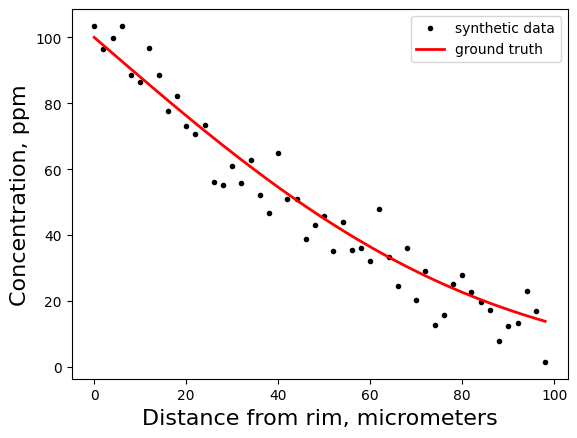

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import scipy
from scipy.optimize import curve_fit

from scipy.special import erfc

def forward_model(x, D, c0):
    """This is the foward model: solution in 1D of Fick diffusion
    
    Parameters
    ----------
    x : 1d array
        the distance in microns
    D : float
        the diffusion coefficient, in log10 m2 s-1
    c0 : float
        the concentration at the border
        
    Returns
    -------
    c(x) : array
        the array of the concentrations at x
    """
    t = 192.0*3600 # time is defined here
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))

##
# We re-generate the synthetic data
##
x_synthetic = np.arange(0, 100,  2.0) # microns
D_synthetic = -14.5 # log10 m2 s-1
c0_synthetic = 100.0 # ppm

y_synthetic = forward_model(x_synthetic, D_synthetic, c0_synthetic)

noise_synthetic = np.random.randn(len(x_synthetic))*7.0
y_synthetic_noisy = y_synthetic + noise_synthetic
noise_synthetic = np.abs(noise_synthetic)

plt.figure()
plt.plot(x_synthetic,y_synthetic_noisy,"k.",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")

plt.xlabel("Distance from rim, micrometers",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend(loc="best")

### Getting parameters uncertainties using the covariance matrix at the optimal solution

Close to the optimal point, the shape of a least-square misfit function looks like a Gaussian dwell. The mean positions of this dwell actually are the optimal values of the parameters. As any Gaussian multivariate function, you can also get access to its covariance matrix, which contains information about the variance of the parameters.

`curve_fit` returns the covariance matrix that you can use to calculate the standard errors that affect your parameters:

In [2]:
popt, pcov = curve_fit(forward_model, x_synthetic, y_synthetic_noisy, 
                         sigma=noise_synthetic, 
                         absolute_sigma=True,
                         p0 = [-15.0, 80.0])

# 1-sigma parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

# we print things with a bit of string formating (see Python docs)
print("Value of D is {:.3f} +/- {:.3f}".format(popt[0],perr[0]))
print("Value of c0 is {:.1f} +/- {:.1f}".format(popt[1],perr[1]))

Value of D is -14.499 +/- 0.004
Value of c0 is 99.6 +/- 0.7


The errors on the $D$ and $c0$ parameters look very small. In other terms, they do not look real. This is often the case when trying to estimate errors on parameters using the covariance matrix. The obtained errors are not always reliable, or in other terms, they are very often not the good ones because the shape of the objective function is far from an ideal multivariate Gaussian (go back to the previous notebook if you need to be convinced for this problem). Plus, if you are using an objective function different from least squares, well you don't have access to the covariance function... it does not exist!

To circumvent this problem, we can use different methods. Among those, two are interesting:

- Bootstrapping allows you to estimate parameters error from the statistical sampling of your data
- Markov-Chain Monte Carlo (MCMC) is another interesting method, which further allows you to use prior estimates for your parameters

### Bootstrapping (non-parametric)

The idea is to generate n subsamples (with replacement) from our dataset, fit them, and estimate the errors on the parameters based on those n fits.

Efron (1979) proved that, given you have sufficient samples, this methods works very well and allows retrieving errors on parameters without assumptions on their statistical distributions or without using more complex methods such as MCMC.

Text(0.5, 1.0, 'Bootstrapping')

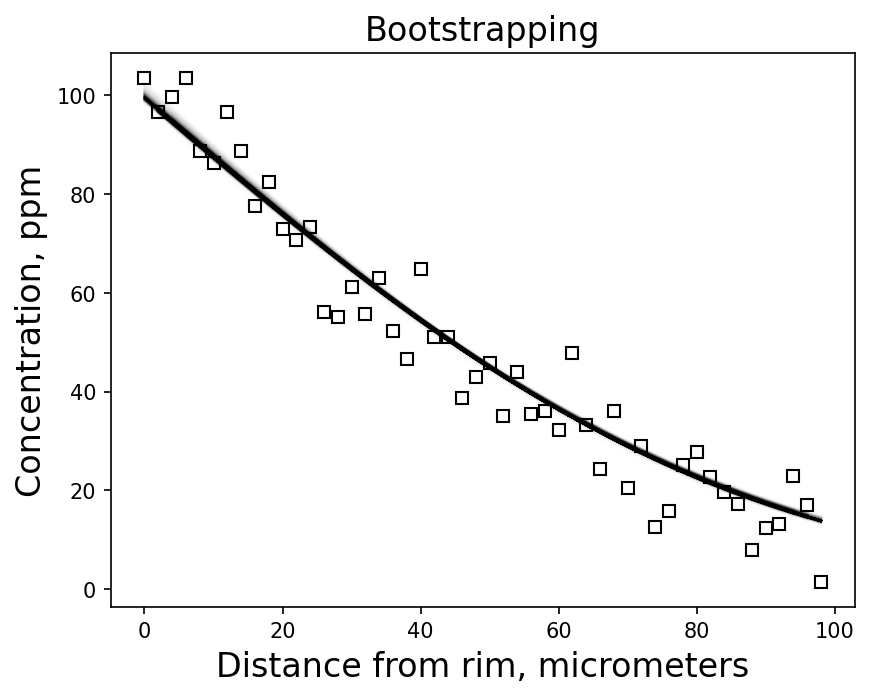

In [3]:
# put x, y and errors together
data_ = np.vstack((x_synthetic, y_synthetic_noisy, noise_synthetic)).T

# variable for the number of bootstrapping iterations
n_iter = 1000

# create an array to record model values
model_bootstrap = []

# plot the original data
plt.figure(dpi=150)
plt.plot(data_[:,0], data_[:,1],"ks", mfc="none")

# below we generate n_iter subsamples and fit them
# we then store the estimated parameters in model_bootstrap
# this will allow us to get an estimate later of the distribution of model parameters
for i in range(n_iter):

    # we use numpy.random.choice
    # to get random line indexes with replacement
    random_lines = np.random.choice(len(data_), len(data_))
    subsample = np.copy(data_[random_lines,:])

    # fit 
    popt_, pcov_ = curve_fit(forward_model, 
                           subsample[:,0], # X subsample
                           subsample[:,1], # Y subsample
                           sigma=subsample[:,2], # error subsample
                           absolute_sigma=True,
                           p0=[-15.5,80.])
    
    # appending the best parameters to my recording list
    model_bootstrap.append(popt_)
    
    # showing the predicted curve
    plt.plot(np.sort(subsample[:,0]), forward_model(np.sort(subsample[:,0]),*popt_),"k-", alpha=0.005)
    
plt.xlabel("Distance from rim, micrometers",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.title("Bootstrapping",fontsize=16)

Below we transform `model_bootstrap` in a numpy array for practical reasons, and then we plot histograms for D and c0. We can compare their distribution with the Gaussian distribution that can be drawn using the `popt` and `pcov` arrays from curve_fit().




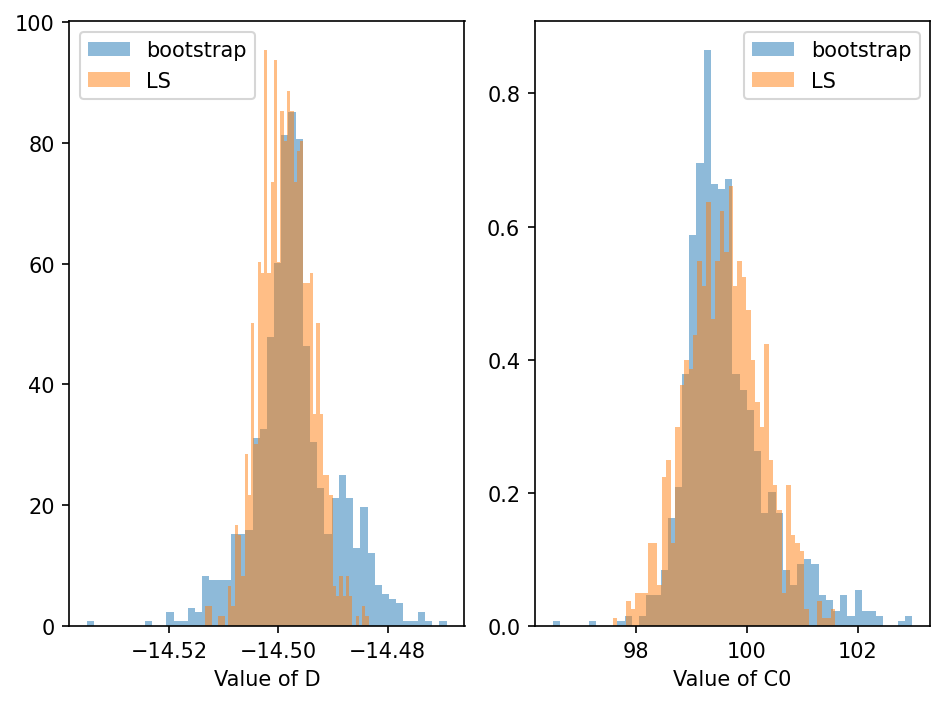

In [4]:
# WE transform the list into an array
model_bootstrap_array = np.array(model_bootstrap)

# plotting histograms
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.hist(model_bootstrap_array[:,0].ravel(),density=True, bins=50,label="bootstrap", alpha=0.5)
plt.hist(np.random.normal(loc=popt[0],scale=perr[0],size = n_iter),
         bins = 50,density=True,label="LS", alpha=0.5)

plt.xlabel("Value of D")
plt.legend()

plt.subplot(1,2,2)
plt.hist(model_bootstrap_array[:,1].ravel(), density=True,bins=50,label="bootstrap", alpha=0.5)
plt.hist(np.random.normal(loc=popt[1],scale=perr[1],size = n_iter),
         bins = 50,density=True,label="LS", alpha=0.5)

plt.xlabel("Value of C0")
plt.legend()
plt.tight_layout()

We see that the error distribution of the parameters is not Gaussian, as could be expected from the shape of the objective function. Therefore, ideally one should not report 1-sigma standard deviations as errors for those parameters, but the quantiles.

## Error propagation

OK now we know how to get estimates for error bars using either the covariance matrix at the optimal solution, or bootstrapping. 

Wait, how do we use those?

This belongs to the domain of error propagation.

Error propagation is a true problem in itself. It is very important as it really determines the way you think about a problem.

If you have normally-distributed errors, there are several easy formula for error propagation, use Google, you will find them. I also provide an additional notebook Supplementary_04_ErrorPropagation.ipynb that gives an example of propagating errors that follow a normal distribution.

However, for the present problem, it is not possible because the posterior distributions of model parameters are not normal, as revealed by the bootstrap we did.

In this case, the simplest and safest way to propagate the errors is to use the samples of parameters obtained by bootstrap to actually evaluate the error on model predictions. Indeed, Bootstrapping allowed use to obtain samples of the parameters that are representative of their true posterior probability distribution. If we use those samples, we also can calculate samples of predicted y values. This allows us to predict y with taking into account for the uncertainties on model parameters.

We do that below:

In [5]:
# we will save the many y predictions in an array containing 
# in lines the boostrap samples, and in columns the y values
y_bootstrapped = np.ones((len(model_bootstrap_array), len(x_synthetic)))
for i in range(len(model_bootstrap_array)):
    y_bootstrapped[i,:] = forward_model(x_synthetic, 
                         model_bootstrap_array[i,0], 
                         model_bootstrap_array[i,1])
    
# we then calculate the 2.5 and 97.5 confidence intervals:
y_pred_lb, y_pred_median, y_pred_hb = np.quantile(y_bootstrapped, (0.025, 0.5, 0.975), axis=0)

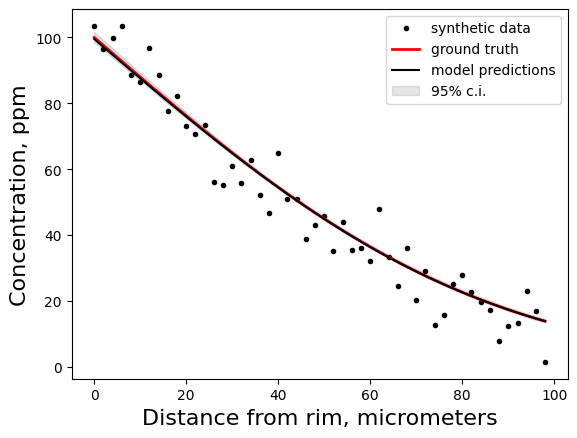

In [6]:
plt.figure()

plt.plot(x_synthetic,y_synthetic_noisy,"k.",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")

plt.xlabel("Distance from rim, micrometers",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend(loc="best")

# plot model and 95% confidence interval
plt.plot(x_synthetic, y_pred_median,"k-", label="model predictions")  
plt.fill_between(x_synthetic, y_pred_lb, y_pred_hb, 
                 alpha=0.1, color="k", label="95% c.i.")
plt.legend(loc="best")
plt.show()

In this case, it turns out that the covariance matrix was providing uncertainty estimates on $D$ and $c0$ that are decent. Bootstrapping allowed us to check for this.